## Importing Libraries

In [1]:
import numpy as np
import gdal
import ogr, osr
import matplotlib.pyplot as plt
import geoconvert

### Supporting Functions
#### To remap array

In [2]:
def remap_array(arr):
    """
    Remapping [3, 256,256] to [256,256,3]
    """
    return np.moveaxis(arr, 0, 2)

#### WKT to EPSG conversion

In [3]:
def wkt2epsg(wkt):

    """
    From https://gis.stackexchange.com/questions/20298/is-it-possible-to-get-the-epsg-value-from-an-osr-spatialreference-class-using-th
    Transform a WKT string to an EPSG code

    Arguments
    ---------

    wkt: WKT definition

    Returns: EPSG code

    """

    p_in = osr.SpatialReference()
    s = p_in.ImportFromWkt(wkt)
    if s == 5:  # invalid WKT
        return None
    if p_in.IsLocal() == 1:  # this is a local definition
        return p_in.ExportToWkt()
    if p_in.IsGeographic() == 1:  # this is a geographic srs
        cstype = 'GEOGCS'
    else:  # this is a projected srs
        cstype = 'PROJCS'
    an = p_in.GetAuthorityName(cstype)
    ac = p_in.GetAuthorityCode(cstype)
    if an is not None and ac is not None:  # return the EPSG code
        return int(p_in.GetAuthorityCode(cstype))

### Path location of raster dataset and shapefiles

In [4]:
path_tif = '../data/City.tif'
path_shp = '../data/clip_shp_geo.shp'

### Path location of output raster dataset

In [5]:
dst_path = '../data/City_clipped.tif'
dat_path_bbox = '../data/City_clipped_bbox.tif'
dst_shp = '../data/shp_proj.shp'

### Defining formats of datasets

In [6]:
RasterFormat = 'GTiff'
VectorFormat = 'ESRI Shapefile'

### Reading input raster dataset

In [7]:
src_ds = gdal.Open(path_tif)

In [8]:
if src_ds is not None:
    print('Source raster dataset loaded')
else:
    raise(Exception('Error loading data'))

Source raster dataset loaded


### Checking projection system of input raster and vector file
These projection must be same else clipping is not possible

In [9]:
VectorDriver = ogr.GetDriverByName(VectorFormat)
VectorDataset = VectorDriver.Open(path_shp, 0) # 0=Read-only, 1=Read-Write

In [10]:
layer = VectorDataset.GetLayer()

In [11]:
vector_proj = layer.GetSpatialRef().ExportToWkt()

In [12]:
Projection = src_ds.GetProjectionRef()

In [13]:
if not int(wkt2epsg(Projection)) == int(wkt2epsg(vector_proj)):
    
    data = geoconvert.vector()

    # Loading data
    data.path_input = path_shp
    data.config()

    # Converting data
    data.toshp(epsg=int(wkt2epsg(Projection)), path_toshp=dst_shp)
    path_shp = dst_shp

converting to shp
poly to multi poly
Successfully converted : ../data/shp_proj.shp


### Reading projection information of raster dataset

In [14]:
# Open datasets
Projection = src_ds.GetProjectionRef()

### Clipping exactly as shapefile given

In [15]:
OutTile = gdal.Warp(dst_path, src_ds, 
                    format=RasterFormat, 
                    dstSRS=Projection, 
                    cutlineDSName=path_shp,
                    cropToCutline=True, 
                    multithread=True)

### Visualizing results

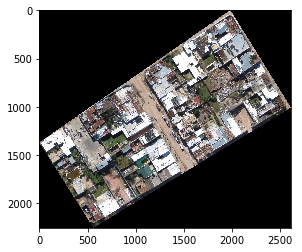

In [16]:
arr = remap_array(OutTile.ReadAsArray())
plt.imshow(arr)

### Saving to Disk

In [17]:
OutTile.FlushCache()
OutTile = None # Close dataset
Raster = None
print("Done.")

Done.


### Clipping as bounding box of shapefile given

#### Reading vector data to extract bounds

In [18]:
VectorDriver = ogr.GetDriverByName(VectorFormat)
VectorDataset = VectorDriver.Open(path_shp, 0) # 0=Read-only, 1=Read-Write
layer = VectorDataset.GetLayer()
feature = layer.GetFeature(0)
geom = feature.GetGeometryRef() 
minX, maxX, minY, maxY = geom.GetEnvelope() # Get bounding box of the shapefile feature

####  Clipping from datasource

In [19]:
OutTile = gdal.Warp(dat_path_bbox, src_ds, 
                    format=RasterFormat, 
                    outputBounds=[minX, minY, maxX, maxY], 
                    dstSRS=Projection, 
                    multithread=True)

#### Visualizing results

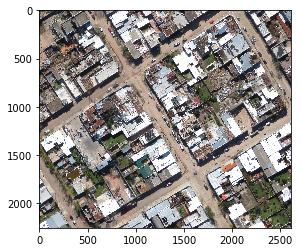

In [20]:
arr = remap_array(OutTile.ReadAsArray())
plt.imshow(arr)

#### Saving to Disk

In [21]:
OutTile.FlushCache()
OutTile = None # Close dataset

Raster = None
VectorDataset.Destroy()
print("Done.")

Done.
